In [2]:
#load packages
using Pkg

Pkg.activate("..")

using DifferentialEquations, Plots, DataFrames, CSV, StatPlots, Distributions, GLM, LaTeXStrings
Plots.gr()

Plots.GRBackend()

# Introduction 

This notebook contains the code to get the respiration of interacting pairs of microbes. This is done in lieu of an analytical solution of the paired interaction model. The growth of a single microbe can be represented as:

\begin{align}
    \frac{1}{C}\frac{dC}{dt} = \mu - R
\end{align}

Where $C$ is the carbon biomass, $\mu$ and $R$ are the effective carbon uptake (including the inefficiency) and maintenance respiration. Species interactions in this model may be included via alteration of the uptake rate $\mu$ as interactions either alter the maximal uptake rate or the efficency of allocation to biomass. The model for the growth of a pair of species is then:

\begin{align}
    \frac{1}{C_1}\frac{dC_1}{dt} &= \mu_1 + C_2 \alpha_{12} - R_{1} \\
    \frac{1}{C_2}\frac{dC_2}{dt} &= \mu_2 + C_1 \alpha_{21} - R_{2}
\end{align}

where the new term $\alpha_{ij}$ is the effect of species $j$ on the uptake rate of species $i$. To get the temperature dependence of these parameters we need to substitute the Arrhenius equation for the uptake and respiration terms:
\begin{align}
    B(T) = B_0 e^{-E (T_r - T_{ra})}
\end{align}

# Parameterisation

I will parameterise the model using the data from Tom Smith's work for now. These include paired measures of growth and respiration from bacteria in the exponential phase. Given that this growth is effectively the net growth rate (i.e. r = $\frac{1}{C}\frac{dC_1}{dt}$) we can get the uptake rate using $\mu = r + R$. I will vary the interaction parameters such that they remain equal (i.e $a_{12} = a_{21}$) and may take either positive (representing facilitation) or negative (representing competition) values. 

In [3]:
params_df = CSV.read("../data/Params_het_all.csv")
head(params_df)

,,strain,rE_sch,rB0_sch,RE_sch,RB0_sch,uB0_sch,uE_sch
1,1,04_04_02,0.756664,0.220453,0.620351,351.739,351.96,0.620436
2,2,04_04_04,0.598957,0.270637,0.547523,56.3867,56.6573,0.547769
3,3,04_04_05,0.840216,0.415501,0.621618,8.90304,9.31854,0.631365
4,4,04_04_06,1.26033,0.0219743,1.24529,40.6478,40.6697,1.24529
5,5,04_RT_01,0.890902,0.337841,0.562771,24.2305,24.5683,0.567283
6,6,04_RT_02,1.4254,0.0386528,1.31472,251.933,251.972,1.31474


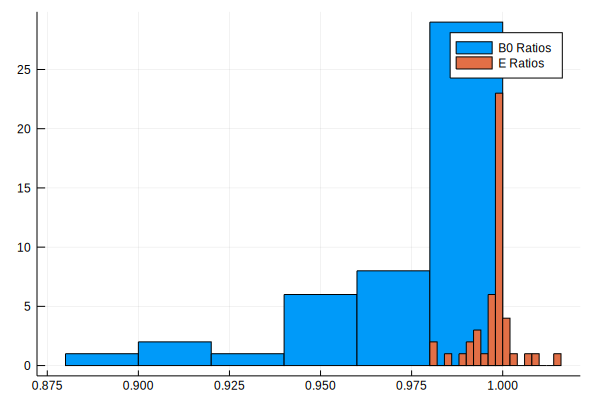

In [4]:
B0_R_u_ratios = params_df[:RB0_sch] ./ params_df[:uB0_sch]
E_R_u_ratios = params_df[:RE_sch] ./ params_df[:uE_sch]

histogram(B0_R_u_ratios,labels = ["B0 Ratios","E Ratios"],bins = 6)
histogram!(E_R_u_ratios,labels = ["B0 Ratios","E Ratios"])

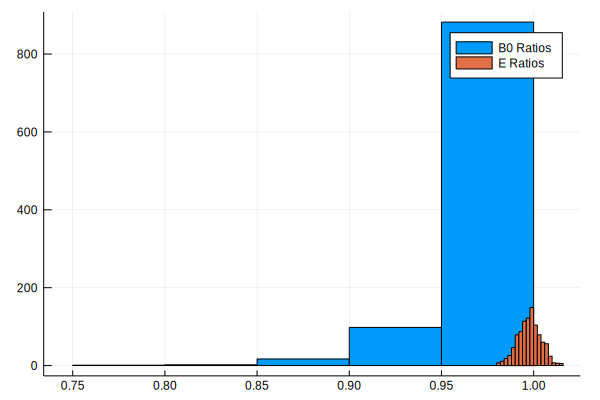

In [5]:
dB_0 = fit(Beta, B0_R_u_ratios)
dE = fit(Normal, E_R_u_ratios)
histogram(rand(dB_0,1000),labels = ["B0 Ratios","E Ratios"],bins=6)
histogram!(rand(dE,1000),labels = ["B0 Ratios","E Ratios"])

# Simulation
Here I create the code to run the simulations. I use the julia `DifferentialEquations` package

First I define the parameter structures to be used in the simulations

In [6]:
#defining constant
const k = 8.617e-5

#defining parameters
struct Boltz
    B_0::Float64
    E::Float64
end

struct Params
    u_1::Boltz;  u_2::Boltz
    a_12::Boltz; a_21::Boltz
    R_1::Boltz; R_2::Boltz
end

struct SimParams
    p::Params
    T::Float64
    d1::Float64
    d2::Float64
end

Then I create a helper function to automatically generate a `Params` object from the data

In [7]:
#parameter creating function
function parameters(sp1::Int64,sp2::Int64,a::Float64)
    @assert sp1 > 0 && sp2 > 0
    @assert sp1 <= nrow(params_df) && sp2 <= nrow(params_df)
    
    u1 = Boltz(params_df[:uB0_sch][sp1],params_df[:uE_sch][sp1])
    u2 = Boltz(params_df[:uB0_sch][sp2],params_df[:uE_sch][sp2])
    
    R1 = Boltz(params_df[:RB0_sch][sp1],params_df[:RE_sch][sp1])
    R2 = Boltz(params_df[:RB0_sch][sp2],params_df[:RE_sch][sp2])
    
    a1 = Boltz(a,0.1)
    a2 = Boltz(a,0.1)
    
    p = Params(u1,u2,a1,a2,R1,R2)
    return(p)
end

function sim_params(p,T)
    #get growth and resp
    u1, u2 = boltz(p.u_1,T) , boltz(p.u_2,T)
    R1, R2 = boltz(p.R_1,T) , boltz(p.R_2,T)
    sim_p = SimParams(p,T,u1-R1,u2-R2)
return(sim_p)
end

#Boltzmann helper function
function boltz(b::Boltz,T::Float64)
    return(b.B_0 * exp(- b.E/k * ((1/T) - (1/295.0)) ))
end

boltz (generic function with 1 method)

I also define the system of equations

In [8]:
#Defining problem
function paired_growth(dC,C,p,t)
    dC[1] = C[1] * (boltz(p.p.u_1,p.T) + (boltz(p.p.a_12,p.T) * C[2]) - boltz(p.p.R_1,p.T))
    dC[2] = C[2] * (boltz(p.p.u_2,p.T) + (boltz(p.p.a_21,p.T) * C[1]) - boltz(p.p.R_2,p.T))
end

paired_growth (generic function with 1 method)

Here is a test simulation using the code above

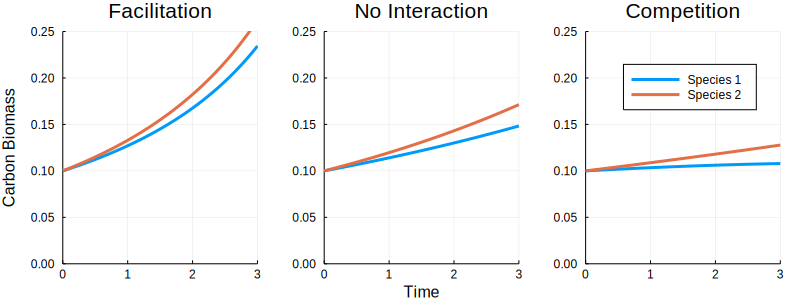

In [9]:
C0 = [0.1,0.1]
tspan = (0.0,3.0)

#no interactions
p = parameters(1,5,0.0)
p = sim_params(p,290.0)
prob = ODEProblem(paired_growth,C0,tspan,p)
sol_none = solve(prob,force_dtmin=true)
p1 = plot(sol_none,xlabel="Time",legend=:false,ylim=(0,0.25),title = "No Interaction")

#with faciliatation
p = parameters(1,5,1.0)
p = sim_params(p,290.0)
prob = ODEProblem(paired_growth,C0,tspan,p)
sol_fac = solve(prob,force_dtmin=true)
p2 = plot(sol_fac,xlabel="",ylabel="Carbon Biomass",ylim=(0,0.25),title="Facilitation",legend=:false)

#with competition
p = parameters(1,5,-1.0)
p = sim_params(p,290.0)
prob = ODEProblem(paired_growth,C0,tspan,p)
sol_comp = solve(prob,force_dtmin=true)
p3 = plot(sol_comp,xlabel="",labels = ["Species 1", "Species 2"],
    ylim=(0,0.25),title="Competition",legend=:topright)


all_plot = plot(p2,p1,p3,layout = (1,3),size=(800,300))
savefig(all_plot,"figures/simulations/single_pair_biomass.png")
all_plot

I can express this as a function of t to see the relationship between time and flux

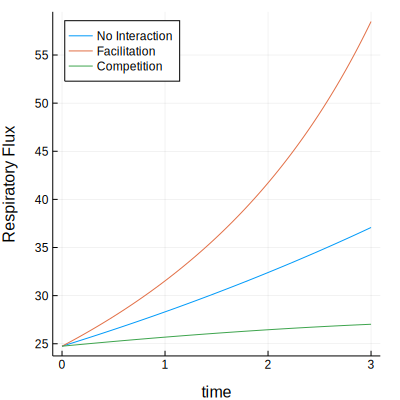

In [10]:
t_vec = Base.range(0,stop = 3,length = 100)

R_none = [sum(sol_none(t) .* [boltz(p.p.R_1,p.T),boltz(p.p.R_2,p.T)]) for t in t_vec]
R_fac = [sum(sol_fac(t) .* [boltz(p.p.R_1,p.T),boltz(p.p.R_2,p.T)]) for t in t_vec]
R_comp = [sum(sol_comp(t) .* [boltz(p.p.R_1,p.T),boltz(p.p.R_2,p.T)]) for t in t_vec]

R_all = hcat(R_none,R_fac,R_comp)

all_plot = plot(t_vec,R_all,labels=["No Interaction","Facilitation","Competition"],legend = :topleft,
        xaxis = "time", yaxis = "Respiratory Flux",size = (400,400))

savefig(all_plot,"figures/simulations/single_pair_time.png")
all_plot

We can also look at the flux at a given time point across a range of temperatures

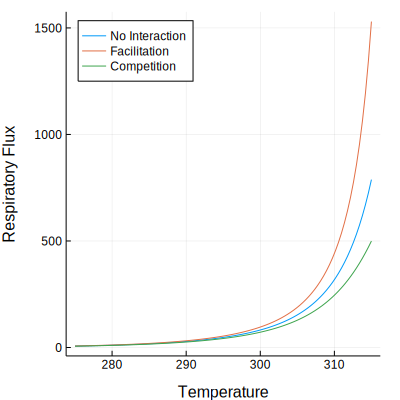

In [11]:
T_vec = range(275.0,stop = 315.0, length = 100)

function temp_sim(a,T_vec)
    C0 = ones(2)./10
    tspan = (0.0,1.0)

    #no interaction
    result = Vector{Float64}(undef, 100)

    for i in 1:100
        p = sim_params(parameters(1,5,a),T_vec[i])
        prob = ODEProblem(paired_growth,C0,tspan,p)
        sol = solve(prob,force_dtmin=true)
        result[i] = sum(sol(1) .* [boltz(p.p.R_1,p.T),boltz(p.p.R_2,p.T)])
    end

    return(result)
end

#none
r1 = (temp_sim(0.0,T_vec))
r2 = (temp_sim(1.0,T_vec))
r3 = (temp_sim(-1.0,T_vec))
r_all = hcat(r1,r2,r3)

all_plot = plot(T_vec,r_all,xaxis = "Temperature", yaxis = "Respiratory Flux", legend = :topleft,
     labels=["No Interaction","Facilitation","Competition"],size = (400,400))

savefig(all_plot,"figures/simulations/single_pair_temp.png")
all_plot

We can then take this and get a value for the temperature sensitvity of respiration for the two species system.

In [12]:
data = DataFrame(T=1 ./ (k .* T_vec),R1=log.(r1),R2=log.(r2),R3=log.(r3))
data = stack(data,[:R1,:R2,:R3])

ols = lm(@formula(value ~ T*variable), data)


StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: value ~ 1 + T + variable + T & variable

Coefficients:
                    Estimate Std.Error  t value Pr(>|t|)
(Intercept)          37.4008  0.489487  76.4081   <1e-99
T                  -0.848108 0.0124136 -68.3208   <1e-99
variable: R2          2.8367  0.692238  4.09786    <1e-4
variable: R3        -2.06576  0.692238 -2.98417   0.0031
T & variable: R2  -0.0674111 0.0175555 -3.83988   0.0002
T & variable: R3   0.0486303 0.0175555  2.77009   0.0060


# The effects of interactions

Here I systematicly look at the effects of interactions on the temperature sensitvity of respiratory flux. To do this i take a set of random species pairs and get the temperature sensitvity of respiration across a gradient of interactions (from competition to facilitaiton). I then get a plot of $E_R$ vs $\alpha$. First I need to write a function to preform the simulations across a range of interaction strengths 

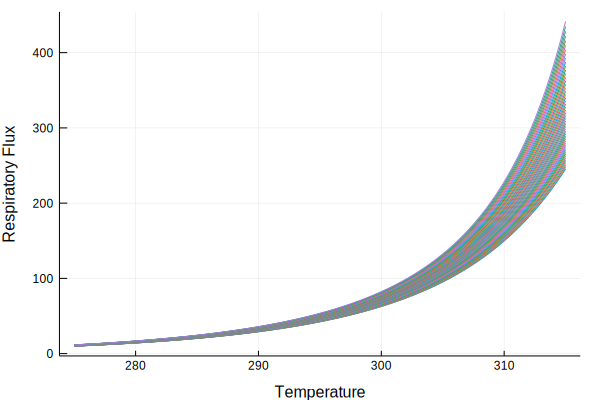

In [13]:
function sim_int_temp(sp1,sp2)
    
    C0 = ones(2)./10
    tspan = (0.0,1.0)
    T_vec = range(280.0,stop = 310.0,length = 100)
    a_vec = range(-1.0,stop = 1.0,length = 50)
    
    results = Array{Float64,2}(undef,100,50)    
    
    for a in 1:50
        a_ = a_vec[a]
        p_a = parameters(sp1,sp2,a_vec[a])
        
        for T in 1:100
            p = sim_params(p_a,T_vec[T])
            prob = ODEProblem(paired_growth,C0,tspan,p)
            sol = solve(prob,force_dtmin=true)
            results[T,a] = sum(sol(1) .* [boltz(p.p.R_1,p.T),boltz(p.p.R_2,p.T)])
        end        
    end
    return(results)
end

sim = (sim_int_temp(1,5))
p1 = plot(T_vec,sim,legend = false, xaxis = "Temperature", yaxis = "Respiratory Flux")
# p2 = plot(1/(k*T_vec),sim,legend = false, xaxis = "Temperature", yaxis = "Respiratory Flux", yaxis = :log)

plot(p1)

then a function that tests lots of random species pairs

In [66]:
using IterTools
sp_pairs = collect(subsets(1:nrow(params_df),2))
nPairs = 100
sp_pairs_rand = rand(sp_pairs,nPairs)
results_a_ER = Vector(undef,nPairs)

for i in 1:nPairs
    print(i)
    results_a_ER[i] = sim_int_temp(sp_pairs_rand[i][1],sp_pairs_rand[i][2])
end

123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100

In [104]:
results = Array{Float64,2}(undef,50,nPairs)
r2 = Array{Float64,2}(undef,50,nPairs)
for i in 1:nPairs
    R = results_a_ER[i]
    for j in 1:50
        data = DataFrame(R = log.(R[:,j]),T = 1 ./ (k .* T_vec))
        ols = lm(@formula(R ~ T), data)
        results[j,i] = coef(ols)[2]
        r2[j,i] = stderror(ols)[2]
    end
end

a_vec = range(-1.0,stop = 1.0,length = 50)

p1 = plot(a_vec,-results,legend = false,yaxis= "E")

#normalising the result
results_norm = mapslices(x -> x ./ x[25], -results, 1)
p2 = plot(a_vec,results_norm,legend = false, yaxis = "Normalised E")

all_plot = plot(p1,p2,size=(800,300),xaxis="Interaction Strength")
savefig(all_plot,"figures/simulations/multi_pair_interaction.png")
all_plot

MethodError: MethodError: no method matching mapslices(::getfield(Main, Symbol("##25#26")), ::Array{Float64,2}, ::Int64)
Closest candidates are:
  mapslices(::Any, ::AbstractArray; dims) at abstractarray.jl:1888

┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/Tom/.julia/packages/DiffEqBase/b3iNk/src/integrator_interface.jl:128


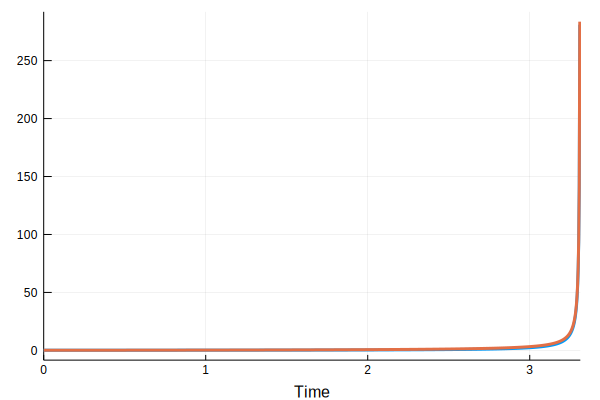

In [21]:
C0 = [0.1,0.1]
tspan = (0.0,5.0)

#no interactions
p = parameters(1,3,1.0)
p = sim_params(p,300.0)
prob = ODEProblem(paired_growth,C0,tspan,p)
sol_none = solve(prob,force_dtmin=true,dtmax=1.0)

p1 = plot(sol_none,xlabel="Time",legend=:false)